In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

In [2]:
# df = pd.read_csv('/Users/newuser/Projects/robust-algo-trader/data/EURUSD/EURUSD_H1_200702210000_202304242100.csv')
df = pd.read_csv('/projects/genomic-ml/da2343/ml_project_2/data/EURUSD/EURUSD_H1_200702210000_202304242100_Update.csv',index_col=0)

# add new Index column
df['Index'] = df.index
df

,Open,High,Low,Close,Volume,Date_Time,SMA_20,SMA_30,SMA_50,SMA_100,...,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index
199,1.31170,1.31190,1.30840,1.30950,583,2007.03.05 12:00:00,1.315585,1.315907,1.317010,1.319517,...,14.167962,-91.269841,1.315508,1.312280,1.309052,-2.608051e+03,-509.905307,55.222567,22.935110,199
200,1.30960,1.31040,1.30810,1.30850,364,2007.03.05 13:00:00,1.315165,1.315623,1.316750,1.319435,...,10.759067,-96.899225,1.314926,1.311160,1.307394,-2.845442e+03,-562.879596,48.156152,22.010781,200
201,1.30860,1.30950,1.30740,1.30830,536,2007.03.05 14:00:00,1.314685,1.315337,1.316476,1.319304,...,10.900308,-92.436975,1.314176,1.310260,1.306344,-2.922013e+03,-557.743660,53.219275,15.875641,201
202,1.30860,1.30990,1.30700,1.30950,550,2007.03.05 15:00:00,1.314215,1.315070,1.316228,1.319193,...,13.069767,-76.190476,1.311821,1.309480,1.307139,-2.523737e+03,-378.214488,53.616348,24.223715,202
203,1.30960,1.31150,1.30960,1.30970,593,2007.03.05 16:00:00,1.313720,1.314843,1.315974,1.319082,...,22.554164,-73.786408,1.310259,1.309100,1.307941,-3.054316e+03,-439.208175,54.883033,32.794015,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100170,1.10237,1.10370,1.10207,1.10294,4538,2023.04.24 17:00:00,1.099604,1.098824,1.097905,1.097007,...,82.909956,-10.689170,1.103770,1.101910,1.100050,-3.906272e+06,1882.860989,61.854336,75.462298,100170
100171,1.10294,1.10323,1.10206,1.10260,3226,2023.04.24 18:00:00,1.099783,1.099061,1.098012,1.097066,...,79.894754,-15.471167,1.104009,1.102100,1.100191,-3.906520e+06,1669.983383,53.062106,72.423007,100171
100172,1.10260,1.10342,1.10249,1.10340,1878,2023.04.24 19:00:00,1.100006,1.099290,1.098121,1.097144,...,80.323058,-4.219409,1.103525,1.102732,1.101939,-3.904723e+06,2002.924994,45.850763,76.811778,100172
100173,1.10341,1.10484,1.10336,1.10441,1730,2023.04.24 20:00:00,1.100292,1.099499,1.098270,1.097231,...,80.174526,-5.212121,1.104581,1.103150,1.101719,-3.903998e+06,2187.640112,45.125640,79.921980,100173


# Candlestick Graph

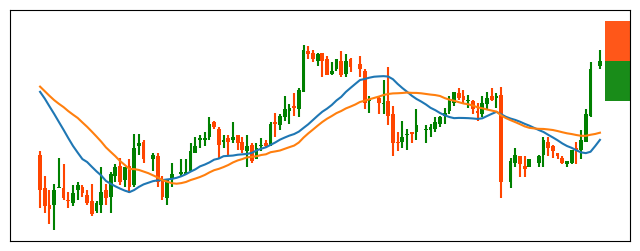

In [24]:
# First 30 rows
# df = df.head(24 * 5)

df = df.head(24*5)

green_df = df[df['Close'] > df['Open']].copy()
green_df["Height"] = green_df["Close"] - green_df["Open"]
red_df = df[df['Close'] < df['Open']].copy()
red_df["Height"] = red_df["Open"] - red_df["Close"]


fig = plt.figure(figsize=(8,3))

##Grey Lines
plt.vlines(x=green_df["Index"], 
           ymin=green_df["Low"], 
           ymax=green_df["High"],
           color="green")
plt.vlines(x=red_df["Index"], 
           ymin=red_df["Low"], 
           ymax=red_df["High"],
           color="orangered")

##Green Candles
plt.bar(x=green_df["Index"], 
        height=green_df["Height"], 
        bottom=green_df["Open"], 
        color="green")
##Red Candles
plt.bar(x=red_df["Index"], 
        height=red_df["Height"], 
        bottom=red_df["Close"], 
        color="orangered")

plt.plot(df["SMA_20"], label="SMA_20")
plt.plot(df["SMA_30"], label="SMA_30")
# plt.plot(df["SMA_50"], label="SMA_50")
# plt.plot(df["SMA_100"], label="SMA_100")

close_price = df["Close"].iloc[-1] # Get the close price of the last row

delta = 0.0025
plt.axhspan(close_price, close_price + delta, facecolor="orangered", xmin= 0.96,  alpha=0.9) 
plt.axhspan(close_price - delta, close_price, facecolor="green", xmin= 0.96,  alpha=0.9) 

        
plt.xticks([])
plt.yticks([])

plt.savefig('plot.png', dpi=128, bbox_inches='tight')

# Show the plot
plt.show()


# Simple Moving Average (SMA) Graph

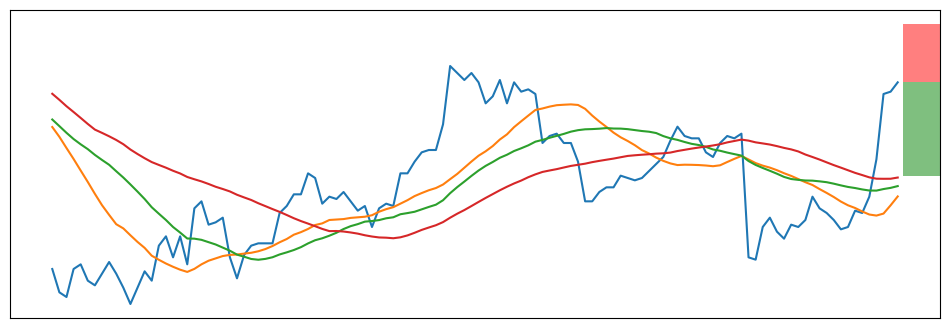

In [25]:
# Plot the price chart with Impulse MACD and its signal line
plt.figure(figsize=(12,4))
# plt.subplot(3, 1, 1) # Create a subplot for the price chart
plt.plot(df["Close"], label="Close")
plt.plot(df["SMA_20"], label="SMA_20")
plt.plot(df["SMA_30"], label="SMA_30")
plt.plot(df["SMA_50"], label="SMA_50")
# plt.plot(df["SMA_100"], label="SMA_100")

close_price = df["Close"].iloc[-1] # Get the close price of the last row

plt.axhspan(close_price, close_price + 0.0025, facecolor="red", xmin= 0.96,  alpha=0.5) 
plt.axhspan(close_price - 0.004, close_price, facecolor="green", xmin= 0.96,  alpha=0.5) 

        
plt.xticks([])
plt.yticks([])

# plt.subplot(3, 1, 2) 
# plt.plot(df["RSI"], label="RSI")
# # plt.axhline(70, color="red", linestyle="--") 
# # plt.axhline(30, color="green", linestyle="--")
# plt.legend()
# plt.title("RSI chart")
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])

# # Plot the ADX graph at the bottom of the plot
# plt.subplot(3, 1, 3)
# plt.plot(df["ADX"], label="ADX")
# plt.legend()
# plt.title("ADX chart")
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])


# plt.savefig('plot.png', dpi=64, bbox_inches='tight')

# Show the plot
plt.show()